In [1]:
!pip install pandas seaborn scikit-learn

# Домашнее задание 3

1. Выбрать номинальное значение как целевую переменную
2. Провести разведочный анализ **включая** анализ зависимости между номинальными переменными (chi2)
3. Выбрать `best_features`
4. Сделать нормализацию данных (scaler, onehotencoding)
4. Обучить модель логистической регрессии
5. Вывести метрики качества, описать полученный результат (также вывести коэфициенты модели)

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [32]:
df = pd.read_csv('student_performance.csv')

In [33]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   student_id               1000000 non-null  int64  
 1   weekly_self_study_hours  1000000 non-null  float64
 2   attendance_percentage    1000000 non-null  float64
 3   class_participation      1000000 non-null  float64
 4   total_score              1000000 non-null  float64
 5   grade                    1000000 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 45.8+ MB


,student_id,weekly_self_study_hours,attendance_percentage,class_participation,total_score,grade
0,1,18.5,95.6,3.8,97.9,A
1,2,14.0,80.0,2.5,83.9,B
2,3,19.5,86.3,5.3,100.0,A
3,4,25.7,70.2,7.0,100.0,A
4,5,13.4,81.9,6.9,92.0,A
...,...,...,...,...,...,...
999995,999996,18.0,95.5,4.8,100.0,A
999996,999997,15.7,82.7,6.7,88.3,A
999997,999998,14.2,85.1,5.8,87.9,A
999998,999999,25.3,90.0,5.3,100.0,A


### EDA

In [35]:
# Бинаризируем часы самообучения относительно медианы
median_study_hours = df['weekly_self_study_hours'].median()
df['study_hours_level'] = df['weekly_self_study_hours'].apply(
    lambda x: 'high' if x > median_study_hours else 'low')

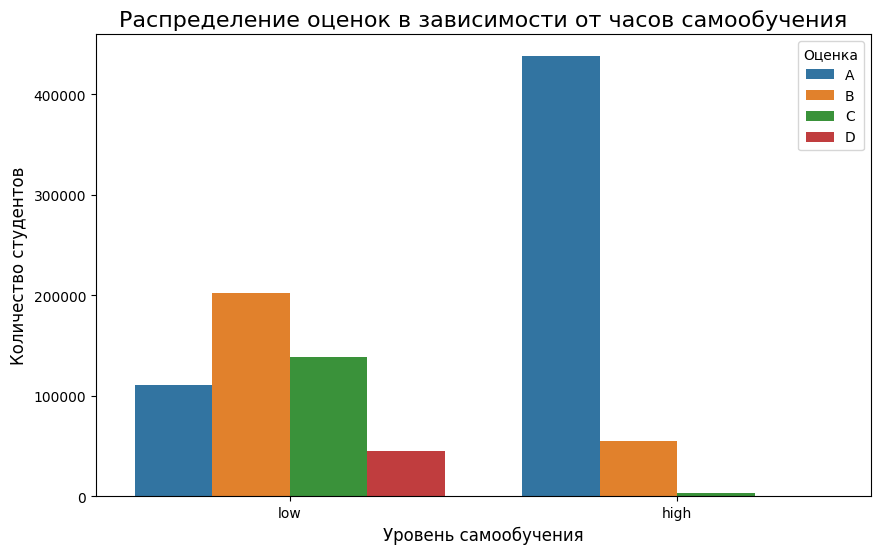

In [38]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='study_hours_level', hue='grade',
              order=['low', 'high'], hue_order=['A', 'B', 'C', 'D'])
plt.title('Распределение оценок в зависимости от часов самообучения', fontsize=16)
plt.xlabel('Уровень самообучения', fontsize=12)
plt.ylabel('Количество студентов', fontsize=12)
plt.legend(title='Оценка')
plt.show()

Из графика видно, что студенты, которые занимаются самостоятельно "много" (high), значительно чаще получают оценку 'A'. В то же время, среди тех, кто занимается "мало" (low), больше студентов с оценками 'C' и 'D'. Это говорит о наличии связи между этими признаками.

Теперь проверим эту зависимость статистически с помощью критерия χ² (хи-квадрат).
Нулевая гипотеза (H0): Связи между уровнем самообучения и оценкой нет.
Альтернативная гипотеза (H1): Связь есть.
Если p-value < 0.05, мы отвергаем нулевую гипотезу и считаем, что зависимость статистически значима

In [39]:
from scipy.stats import chi2_contingency

# Создаем таблицу сопряженности
table = pd.crosstab(df['study_hours_level'], df['grade'])
print("Таблица сопряженности:")
print(table)

# Проводим тест хи-квадрат
chi2, p, dof, expected = chi2_contingency(table)
print(f"\nχ² = {chi2:.2f}")
print(f"p-value = {p}")

Таблица сопряженности:
grade                   A       B       C      D     F
study_hours_level                                     
high               437687   55569    3443     26     0
low                110957  202605  138537  44972  6204

χ² = 457932.30
p-value = 0.0


p-value равно 0.0, что меньше 0.05. Следовательно, мы отвергаем нулевую гипотезу. Статистическая зависимость между количеством часов самообучения и итоговой оценкой подтверждена.

Ном

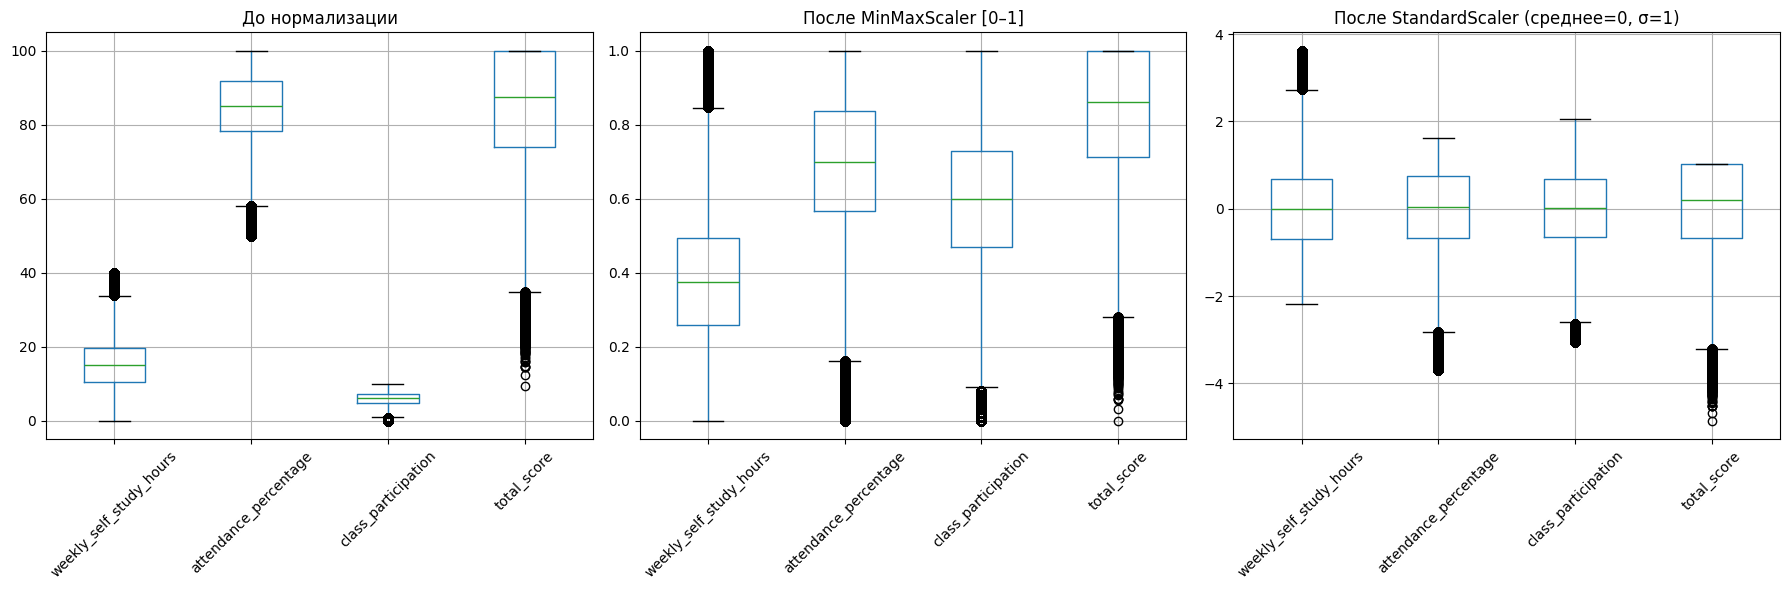

In [58]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Выбираем только числовые признаки для масштабирования (исключая id)
num_df = df.select_dtypes(include=[int, float]).drop(columns=['student_id'])

# Применяем два метода нормализации
minmax_scaler = MinMaxScaler()
std_scaler = StandardScaler()

minmax_scaled_df = pd.DataFrame(minmax_scaler.fit_transform(num_df), columns=num_df.columns)
std_scaled_df = pd.DataFrame(std_scaler.fit_transform(num_df), columns=num_df.columns)

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# До нормализации
num_df.boxplot(ax=axes[0], rot=45)
axes[0].set_title("До нормализации")

# После MinMaxScaler
minmax_scaled_df.boxplot(ax=axes[1], rot=45)
axes[1].set_title("После MinMaxScaler [0–1]")

# После StandardScaler
std_scaled_df.boxplot(ax=axes[2], rot=45)
axes[2].set_title("После StandardScaler (среднее=0, σ=1)")

plt.tight_layout()
plt.show()

**До нормализации:** Признаки имеют совершенно разный масштаб. total_score и attendance_percentage варьируются в широком диапазоне, тогда как class_participation имеет гораздо меньший разброс.

**После MinMaxScaler:** Все значения были успешно "сжаты" в диапазон от 0 до 1.

**После StandardScaler:** Данные были преобразованы так, что их среднее значение равно 0, а стандартное отклонение — 1.

На графиках также видно значительное количество выбросов, особенно для weekly_self_study_hours и total_score. StandardScaler менее чувствителен к таким выбросам, чем MinMaxScaler, что делает его более предпочтительным для нашей модели.

### Model

In [41]:
from sklearn.linear_model import LogisticRegression

In [52]:
y = df['grade']
X = df.drop(columns=['student_id', 'grade', 'study_hours_level'])
X

,weekly_self_study_hours,attendance_percentage,class_participation,total_score
0,18.5,95.6,3.8,97.9
1,14.0,80.0,2.5,83.9
2,19.5,86.3,5.3,100.0
3,25.7,70.2,7.0,100.0
4,13.4,81.9,6.9,92.0
...,...,...,...,...
999995,18.0,95.5,4.8,100.0
999996,15.7,82.7,6.7,88.3
999997,14.2,85.1,5.8,87.9
999998,25.3,90.0,5.3,100.0


In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}") # stratify - разделение данных с учетом распределнеия категориальной переменной

Размер обучающей выборки: (700000, 4)
Размер тестовой выборки: (300000, 4)


In [54]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Создаем конвейер: сначала StandardScaler, затем Логистическая регрессия
model_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=42, multi_class='ovr')) # ovr - One-vs-Rest для мультиклассовой задачи
])

# Обучаем весь конвейер на тренировочных данных
model_pipeline.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(multi_class='ovr', random_state=42))])


Отчет по качеству модели на тестовых данных

Точность (Accuracy): 0.8851

Детальный отчет (Classification Report):
              precision    recall  f1-score   support

           A       0.99      1.00      1.00    164593
           B       0.78      0.98      0.87     77452
           C       0.66      0.49      0.56     42594
           D       0.78      0.21      0.33     13500
           F       1.00      0.56      0.72      1861

    accuracy                           0.89    300000
   macro avg       0.84      0.65      0.70    300000
weighted avg       0.88      0.89      0.87    300000



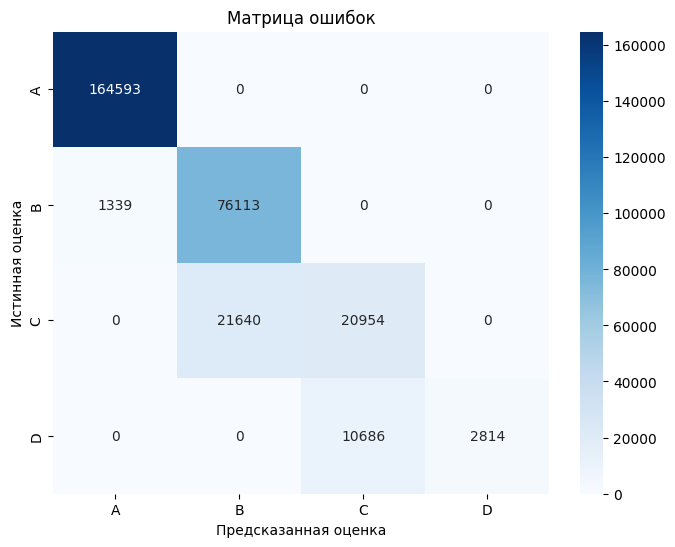

In [60]:
# Делаем предсказания на тестовой выборке
y_pred = model_pipeline.predict(X_test)
y_proba = model_pipeline.predict_proba(X_test)

# Оценка качества модели
print("\nОтчет по качеству модели на тестовых данных\n")
print(f"Точность (Accuracy): {accuracy_score(y_test, y_pred):.4f}\n")

print("Детальный отчет (Classification Report):")
print(classification_report(y_test, y_pred))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred, labels=['A', 'B', 'C', 'D'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['A', 'B', 'C', 'D'], yticklabels=['A', 'B', 'C', 'D'])
plt.title('Матрица ошибок')
plt.ylabel('Истинная оценка')
plt.xlabel('Предсказанная оценка')
plt.show()

Общая точность тестирования модели составила 88.51%, что является высоким показателем. Анализ матрицы ошибок показывает, что основные ошибки происходят между соседними классами, например, когда модель путает оценки 'C' и 'B'.

***Accuracy (0.8851)***

Доля правильно классифицированных объектов.

Модель корректно предсказала итоговую оценку для 88.5% студентов из тестовой выборки. Это свидетельствует о высокой общей эффективности модели.

***Precision (Средневзвешенное: 0.88)***

Какой процент предсказанных положительных оценок действительно является верным.

Модель демонстрирует очень высокую точность для крайних оценок: 99% для 'A' и 100% для 'F'. Это означает, что если модель предсказывает отличную или неудовлетворительную оценку, этому предсказанию можно доверять. Точность для средних оценок ('B', 'C', 'D') ниже, что указывает на периодические ошибки.

***Recall (Средневзвешенное: 0.89)***

Какую долю студентов с реальной оценкой X модель смогла найти.

Полнота модели превосходна для высоких оценок: она находит 100% студентов с оценкой 'A' и 98% с оценкой 'B'. Однако полнота значительно падает для низких оценок: модель обнаружила только 49% студентов с оценкой 'C' и всего 21% студентов с оценкой 'D'. Это главная слабость модели — она пропускает многих студентов со средней и низкой успеваемостью.

***F1-score (Средневзвешенное: 0.87)***

Баланс между точностью и полнотой. Ближе к 1 → модель сбалансирована, ближе к 0 → проблемы с ложноположительными или ложноотрицательными срабатываниями.

Высокий F1-score для оценок 'A' (1.00) и 'B' (0.87) показывает, что модель хорошо сбалансирована для этих классов. Низкие значения для 'C' (0.56) и особенно 'D' (0.33) подчеркивают несбалансированность, вызванную низкой полнотой (Recall).

Итоговый вывод: Модель отлично справляется с идентификацией студентов с высокой успеваемостью, но испытывает трудности с точным определением и нахождением студентов со средними и низкими оценками, часто завышая им результат.